# Example 2: Ghost

This example computes the $H^1$ and $L^2$ (semi-)inner products of two 
functions, $v,w$ with the property that they are the sum of a harmonic 
function and a polynomial.

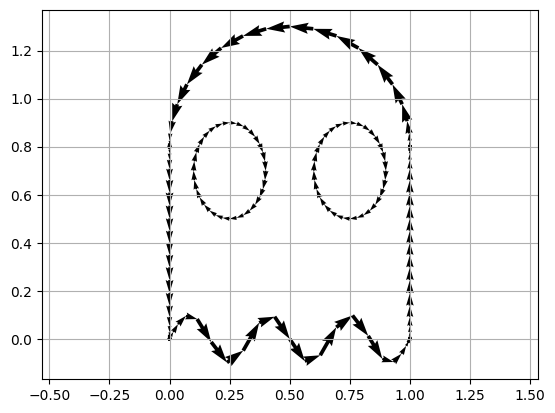

cell object
id: num_edges: 		6
num_holes: 		2
num_pts: 		192
contours: 		[[0, 1, 2, 3], [4], [5]]
hole_int_pts (x): 	[0.75 0.25]
hole_int_pts (y): 	[0.7 0.7]



In [11]:
import puncturedfem as pf
import numpy as np

n = 16
q_trap = pf.quad.quad.quad(qtype='trap', n=n)
q_kress = pf.quad.quad.quad(qtype='kress', n=n)

edge_list = []

# bottom: squiggles
e = pf.mesh.edge.edge(etype='sine_wave', q=q_kress, amp=0.1, freq=6)
edge_list.append(e)

# right: line
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,0], [1,0.8])
edge_list.append(e)

# top: half-circle
e = pf.mesh.edge.edge(etype='circular_arc', q=q_kress, H=0)
e.reflect_across_x_axis()
e.join_points([1,0.8], [0,0.8])
edge_list.append(e)

# left: line
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,0.8], [0,0])
edge_list.append(e)

# right hole
e = pf.mesh.edge.edge(etype='ellipse', q=q_trap, a=0.15, b=0.2)
e.translate([0.75,0.7])
e.reverse_orientation()
edge_list.append(e)

# left hole
e = pf.mesh.edge.edge(etype='ellipse', q=q_trap, a=0.15, b=0.2)
e.translate([0.25,0.7])
e.reverse_orientation()
edge_list.append(e)

# plot edges
pf.plot.edges.edges(edge_list, orientation=True)

# define mesh cell
K = pf.mesh.cell.cell(edge_list)
print(K)

## Define local functions
Consider the functions
\begin{align*}
	v(x) &= \frac{x_1 - 0.25}{(x_1 - 0.25)^2 + (x_2 - 0.7)^2}
	+ x_1^3 x_2 + x_2^2
	~,
	\\[12pt]
	w(x) &= \ln\big[(x_1 - 0.75)^2 + (x_2 - 0.7)^2\big] 
	+ x_1^2 x_2^2 - x_1 x_2^3
	~.
\end{align*}
It holds that 
\begin{align*}
	\Delta v(x) &= 6 x_1 x_2 +2
	~,
	\\[12pt]
	\Delta w(x) &= 2 x_1^2 - 6 x_1 x_2 + 2 x_2^2
	~.
\end{align*}

In [12]:
# get coordinates of boundary points
x1, x2 = K.get_boundary_points()

################################################################################

# trace of v
v_trace = (x1 - 0.25) / ((x1 - 0.25) ** 2 + (x2 - 0.7) ** 2) + \
   (x1 ** 3) * x2 + x2 ** 2

# Laplacian of v
v_laplacian = pf.poly.poly.polynomial()

alpha = pf.poly.multi_index.multi_index_2([1,1])
m = pf.poly.monomial.monomial(alpha, 6.0)
v_laplacian.add_monomial(m)

alpha = pf.poly.multi_index.multi_index_2([0,0])
m = pf.poly.monomial.monomial(alpha, 2.0)
v_laplacian.add_monomial(m)

# store v as a local function object
v = pf.locfun.locfun.locfun(v_trace, v_laplacian)

################################################################################

# trace of w
w_trace = np.log((x1 - 0.75) ** 2 + (x2 - 0.7) ** 2) + \
   (x1 ** 2) * (x2 ** 2) - x1 * (x2 ** 3)

# Laplacian of w
w_laplacian = pf.poly.poly.polynomial() # defaults to zero polynomial

alpha = pf.poly.multi_index.multi_index_2([2,0])
m = pf.poly.monomial.monomial(alpha, 2.0)
w_laplacian.add_monomial(m)

alpha = pf.poly.multi_index.multi_index_2([1,1])
m = pf.poly.monomial.monomial(alpha, -6.0)
w_laplacian.add_monomial(m)

alpha = pf.poly.multi_index.multi_index_2([0,2])
m = pf.poly.monomial.monomial(alpha, 2.0)
w_laplacian.add_monomial(m)

# store w as a local function object
w = pf.locfun.locfun.locfun(w_trace, w_laplacian)

# compute quanties needed for integration
v.compute_all(K)
w.compute_all(K)

## $H^1$ semi-inner product

Let's compute the $H^1$ semi-inner product 
\begin{align*}
	\int_K \nabla v \cdot \nabla w ~dx
	&\approx
	-6.311053612386
	\pm 3.6161 \times 10^{-12}
\end{align*}
whose approximate value was obtained with *Mathematica*. 

In [13]:
h1_vw_computed = v.compute_h1(w, K)
print('Computed H^1 semi-inner product = ', h1_vw_computed)

h1_vw_exact = -6.311053612386
h1_vw_error = abs(h1_vw_computed - h1_vw_exact)
print('Error in H^1 semi-inner product = %.4e'%(h1_vw_error))

Computed H^1 semi-inner product =  -6.309526349522576
Error in H^1 semi-inner product = 1.5273e-03


Let's do the same for the $L^2$ inner product
\begin{align*}
	\int_K v \, w ~dx
	&\approx -3.277578636852
	\pm 1.0856\times 10^{-13}
\end{align*}

In [14]:
l2_vw_computed = v.compute_l2(w, K)
print('Computed L^2 inner product = ', l2_vw_computed)

l2_vw_exact = -3.277578636852
l2_vw_error = abs(l2_vw_computed - l2_vw_exact)
print('Error in L^2 inner product = %.4e'%l2_vw_error)

Computed L^2 inner product =  -3.27744080857697
Error in L^2 inner product = 1.3783e-04


## Convergence Study

|	n	|	H1 error	|	L2 error	|
|-------|---------------|---------------|
|	4	|	2.4336e+00	|	5.9408e-03	|
|	8	|	1.0269e-02	|	1.3086e-02	|
|	16	|	1.5273e-03	|	1.3783e-04	|
|	32	|	5.3219e-07	|	8.1747e-07	|
|	64	|	1.5430e-11	|	4.6189e-11	|

In [15]:
print('H^1 error (vw) = %.4e'%h1_vw_error)
print('L^2 error (vw) = %.4e'%l2_vw_error)

H^1 error (vw) = 1.5273e-03
L^2 error (vw) = 1.3783e-04
